<img src="https://images.unsplash.com/photo-1614680376408-81e91ffe3db7?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=1267&q=80" width="500"><br>
Photo by <a href="https://unsplash.com/@alexbemore?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Alexander Shatov</a> on <a href="https://unsplash.com/s/photos/whatsapp?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a><br>

This notebook is an analysis of my family Whatsapp group. The data contains 40.000 texts, from April-2016 to September-2020. As part of an exercise for a Python course, the text data is processed and sent to a SQL database (sqlite3) and then retrieved using Python. Pandas are then used to build the dataframe and visualisations. 

For obvious reasons, the dataset is private. The language in the dataset is Portuguese. 

## <center style="background-color:Gainsboro; width:40%;">Contents</center>
1. [Data Processing](#1.-Data-Processing)<br>
2. [Data Analysis](#2.-Data-Analysis)<br>
2.1 [Word Counts and Number of Characters](#2.1-Word-Counts-and-Number-of-Characters)<br>
2.2 [Year, Months and Weekdays](#2.2-Year,-Months-and-Weekdays)<br>
2.3 [Most Active Day Period](#2.3-Most-Active-Day-Period)<br>
3. [Conclusion](#3.-Conclusion)<br>

***Please remember to upvote if you find this Notebook helpful!***

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#SQL Data processing
import os
import sqlite3
import re 
import time
import urllib.request, urllib.parse, urllib.error
import zlib
#Plot
import seaborn as sns
import matplotlib.pyplot as plt
#text analysis
import string, os, random
from wordcloud import WordCloud
from textblob import TextBlob 
import calendar

>Importing txt data to SQL

In [2]:
fname = '../input/negriniwhats/WhatsApp.txt'
str_data = open(fname, encoding = 'utf8')
conn = sqlite3.connect('data.sqlite')
cur = conn.cursor()

cur.execute('''DROP TABLE IF EXISTS Messages ''')
cur.execute('''DROP TABLE IF EXISTS Senders ''')

cur.execute('''CREATE TABLE IF NOT EXISTS Messages (
    id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    msgdate TEXT, 
    subject TEXT,
    sender_id INTEGER
    )''')
    
cur.execute('''CREATE TABLE IF NOT EXISTS Senders (
    id     INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT UNIQUE,
    sender   TEXT UNIQUE
    )''')

# Pick up where we left off
start = None
cur.execute('SELECT max(id) FROM Messages' )
try:
    row = cur.fetchone()
    if row is None :
        start = 0
    else:
        start = row[0]
except:
    start = 0
        
def convert24(str1): 
      
    # Checking if last two elements of time 
    # is AM and first two elements are 12 
    if str1[-2:] == "am" and str1[:2] == "12": 
        return "00" + str1[2:-2] 
          
    # remove the AM     
    elif str1[-2:] == "am": 
        return str1[:-2] 
      
    # Checking if last two elements of time 
    # is PM and first two elements are 12    
    elif str1[-2:] == "pm" and str1[:2] == "12": 
        return str1[:-2] 
          
    else: 
          
        # add 12 to hours and remove PM
        hour = re.findall('([0-9]*):',str1) 
        return str(int(hour[0]) + 12) + str1[1:4] 
  
sent_at = None
subject = None
sender = None
time = None

for line in str_data:
    line = line.lower()
    
    try:
        finddate = re.findall('[0-9]{2}/[0-9]{2}/[0-9]{4}',line)
        MDY = finddate[0].split('/')
        DD = MDY[0]
        MM = MDY[1]
        YYYY = MDY[2]
        date = finddate[0]
    except: continue

    try:
        findtime = re.findall(', ([0-9]*:[0-9]{2} [ap]*m)',line)
        time = (convert24(findtime[0]))
    except: continue
    msgdate = YYYY + '-' + MM + '-' + DD + ' ' + time
    
    try:
        findmsg=re.findall(': (.*)',line)
        subject = findmsg[0]
    except: continue

    try:
        findsender = re.findall('- (.*?):',line)
        sender = findsender[0]
    except: continue

    cur.execute('''INSERT OR IGNORE INTO Senders (sender)
        VALUES ( ? )''', ( sender, ) )
        
    cur.execute('SELECT id FROM Senders WHERE sender = ? ', (sender, ))
    sender_id = cur.fetchone()[0]
            
    cur.execute('''INSERT OR IGNORE INTO Messages (id, msgdate,  subject, sender_id)
            VALUES ( ?, ?, ?, ? )''', (start, msgdate, subject, sender_id))

conn.commit()
cur.close()

>Connecting to SQL database and importing Data

In [3]:
#Connect to SQL databse
conn = sqlite3.connect('data.sqlite')
cur = conn.cursor()
#SQL command to select sender ID, Name from Table Senders and create a Dictionary
cur.execute('SELECT id, sender FROM Senders')
senders = dict()
#The What's group actually only contains four integrants and 5 are listed
#Due to phone number change, we need to merge both ID's 8 and 5155
for sender_row in cur :
    if sender_row[0] == 8:
        user = 5155
    else:
        user = sender_row[0]
    senders[user] = sender_row[1]
#SQL command to select sender ID, sender_ID, date and message and create a Dictionary with these values
cur.execute('SELECT id, sender_id,msgdate, subject FROM Messages')
messages = dict()
for message_row in cur :
    if message_row[1] == 8:
        user = 5155
    else:
        user = message_row[1]
    messages[message_row[0]] = (user,message_row[2],message_row[3])

print("Loaded messages: ",len(messages),"senders: ",len(senders))
print("Message Example: \nSender ID: %i \nDate: %s \nMessage: %s"%(messages[15][0],messages[15][1],messages[15][2]))

Loaded messages:  39989 senders:  4
Message Example: 
Sender ID: 1 
Date: 2016-07-30 21:46 
Message: se cuidem


In [4]:
#Now we organise a dictionary with the dates
#Each user has a count for the month
counts = dict()
months = list()
sendcounts = dict()

for (message_id, message) in list(messages.items()):
    sender = message[0]
    #if sender not already in dict it adds
    sendcounts[sender] = sendcounts.get(sender,0) + 1
    #stores month and year of message
    month = message[1][5:7]
    year = message[1][0:4]
    #add month to empty list "months"
    if month not in months : months.append(month)
    #creates a key for year, month and sender ID
    key = (year, month, sender)
    #counts the messages for this specific key
    counts[key] = counts.get(key,0) + 1
    #counts the month total
    tkey = (month,year, 'total')
    counts[tkey] = counts.get(tkey,0) + 1

# Data Processing

So far, we extracted data from the '**.txt**' file, used Python to insert it into the SQL database as an exercise. Then, Python was used to download the SQL data and built the following dictionaries:
* *Senders*: dictionary containing User ID and User Name
* *Counts*: dictionary year, month, user as keys and total per user as values
* *Sendcounts*: dictionary containing User ID and Number of Messages sent
* *Messages*: dictionary containing msg ID, User ID, datetime and msg

Now we start analysing the text data by building the Dataframe and creating additional features. The Messages dictionary is used as a base for our Dataframe:

In [5]:
df = pd.DataFrame.from_dict(messages,orient='index', columns = ['userID','Date','message'])
df.head(3)

,userID,Date,message
1,1,2016-07-30 21:43,e o pior
2,1,2016-07-30 21:43,ele tá de carona
3,1,2016-07-30 21:43,e ainda assim ficou tirando selfie


Next, we map the userID's  to the WhatsApp group members names using the Senders dictionary. A new column 'username' is added:

In [6]:
df['username'] = df['userID'].map(senders.get)
df.head(3)

,userID,Date,message,username
1,1,2016-07-30 21:43,e o pior,talia
2,1,2016-07-30 21:43,ele tá de carona,talia
3,1,2016-07-30 21:43,e ainda assim ficou tirando selfie,talia


## Adding Text Analytical Features

With the current data, we can now start to derive extra features. Features to count the number of words, characters, words per character ratio, and other analytical information are added.

* **Word Count** - Total number of words in the headline
* **Character Count** - Total number of characters in the headline excluding spaces
* **Word Density** - Average length of the words used in the headline
* **Punctuation Count** - Total number of punctuations used in the headline
* **Upper-Case to Lower-Case Words ratio** - ratio of upper case words used and lower case words used in the text

In [7]:
punctuations = string.punctuation

df['word_count'] = df['message'].apply(lambda x : len(x.split()))
df['char_count'] = df['message'].apply(lambda x : len(x.replace(" ","")))
df['word_density'] = df['word_count'] / (df['char_count'] + 1)

#Adding +1 to allow ratio calculation
df['Uppercase'] = df['message'].str.findall(r'[A-Z]').str.len()+1
df['Lowercase'] = df['message'].str.findall(r'[a-z]').str.len()+1
df['UppLowRatio'] = df['Uppercase'] / (df['Lowercase'] + 1)

df['punc_count'] = df['message'].apply(lambda x : len([a for a in x if a in punctuations]))

df.head(3)

,userID,Date,message,username,word_count,char_count,word_density,Uppercase,Lowercase,UppLowRatio,punc_count
1,1,2016-07-30 21:43,e o pior,talia,3,6,0.428571,1,7,0.125000,0
2,1,2016-07-30 21:43,ele tá de carona,talia,4,13,0.285714,1,13,0.071429,0
3,1,2016-07-30 21:43,e ainda assim ficou tirando selfie,talia,6,29,0.200000,1,30,0.032258,0


Additionally, we can also extract the dates for each message to look for patterns later. The following features are created:
* **Weekday** - Weekday name when the message was sent
* **Month** - The name of the month in which the message was sent
* **Year** - Month date in which the message was sent
* **Hour** - Hour value in which the message was sent

In [8]:
#df[df['Date'].str.contains('231:')]
#The Date came with formatting issues
df['Date'] = df['Date'].str.replace('220:','22:0')
df['Date'] = df['Date'].str.replace('231:','23:1')
#Convert Date to datetime format
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S")
#Get Weekdays
df['weekday'] = df['Date'].dt.dayofweek.apply(lambda x : calendar.day_name[x])
df['month'] = df['Date'].dt.month.apply(lambda x : calendar.month_name[x])
df['year'] = df['Date'].dt.year
df['hour'] = df['Date'].dt.hour

Our data comprises the messages from the period:

In [9]:
print('From %s-%d to %s-%d'% (df['month'].min(),df['year'].min(), df['month'].max(),df['year'].max()))

From April-2016 to September-2020


## Data Analysis

To kick off our Data Analysis, let's start with the basics and discover who sent more messages overall:

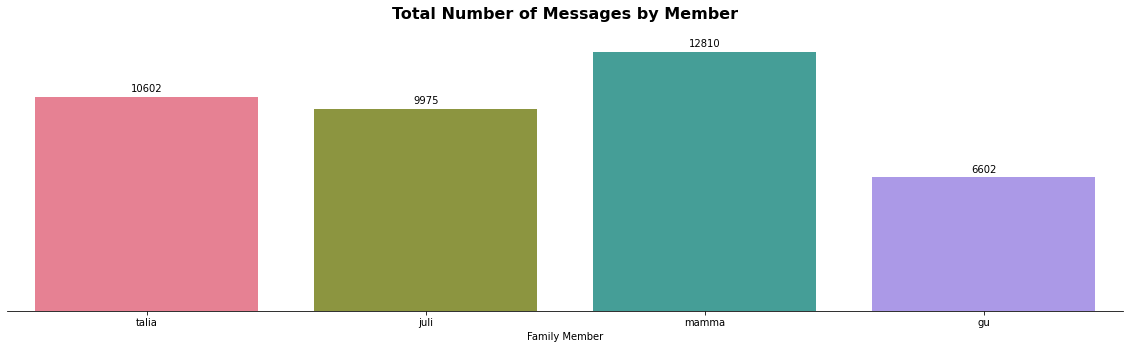

In [10]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x = df['username'], palette = 'husl')
for p in ax.patches:
        ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(0, 3),rotation = 'horizontal',textcoords='offset points')
ax.set_xlabel('Family Member')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False)  
plt.title('Total Number of Messages by Member', fontsize = 16,weight = 'bold',pad=20);  
sns.despine(top=True, right=True, left=True, bottom=False)

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<h3>The Notification is always there</h3>
<ul>
<li>'mamma' has sent 33% of all messages, with approximately 12.800 messages sent
<li>My sister and I are quite close, while my brother is far behind
<li>It is quite astonishing to think that we have exchanged so much information across the years    
<ul>
</blockquote>

# Word Counts and Number of Characters

As an overview of Word Counts and Number of Characters by message, we visualise how their values are distributed:

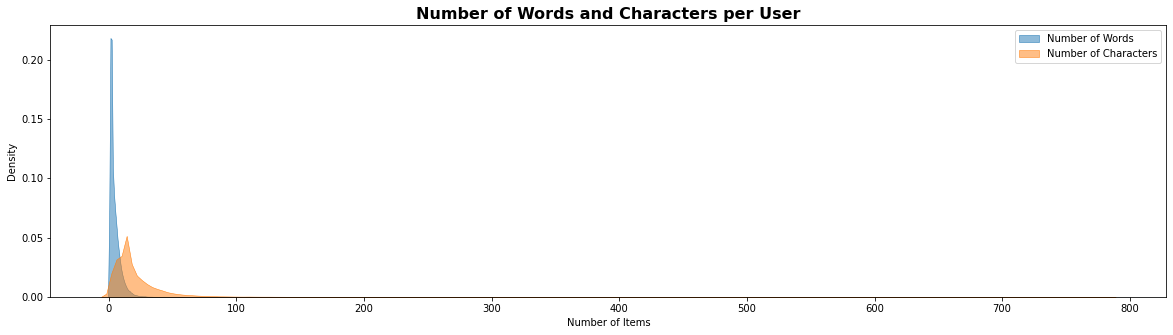

In [11]:
plt.figure(figsize=(20,5))
ax = sns.kdeplot(df['word_count'], linewidth=0.5,label = 'Number of Words', alpha=.5, fill = True)    
ax = sns.kdeplot(df['char_count'], linewidth=0.5,label = 'Number of Characters', alpha=.5, fill = True)   
plt.xlabel("Number of Items")
plt.ylabel("Density")
plt.title("Number of Words and Characters per User",fontsize=16, weight = 'bold'); 
plt.legend();

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<h3>Number of Words and Characters per User</h3>
<ul>
<li>Both Features present a heavier left-tail <br>
A heavier left-tail indicates two things:
<li>The data presents outliers to the right, i.e. there are messages with a significantly higher number of words and characters if compared to the Median of all messages
<li>The left-tail shows that most samples have a small number of words and characters
<ul>
</blockquote>

Since the above analysis indicated the presence of outliers, let's visualise them by using BoxPlots:

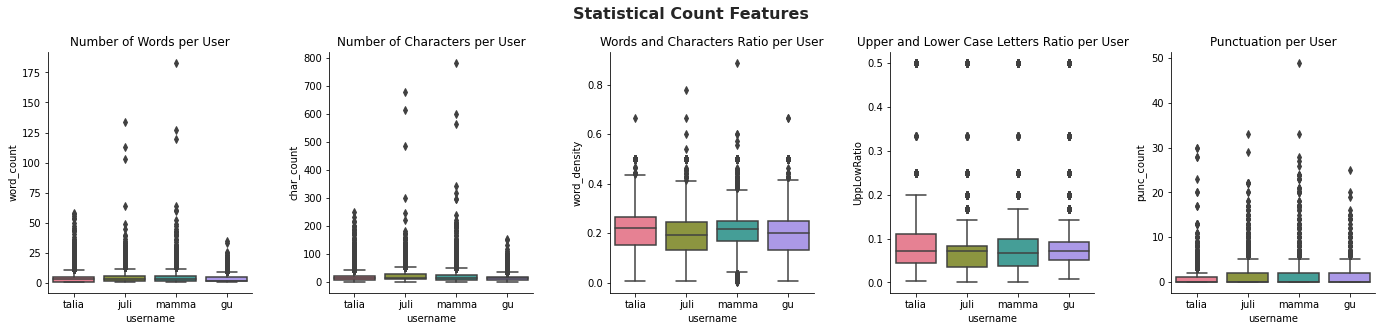

In [12]:
fig, axarr = plt.subplots(1,5, figsize=(20, 5))

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

feats = ['word_count','char_count','word_density','UppLowRatio','punc_count']
z = 0
for j in range(0,5):
    ax = sns.boxplot(data = df, x = 'username', y = df[feats[z]], ax=axarr[j],palette = 'husl');
    z +=1
        
axarr[0].set_title("Number of Words per User")
axarr[1].set_title("Number of Characters per User")
axarr[2].set_title("Words and Characters Ratio per User")
axarr[3].set_title("Upper and Lower Case Letters Ratio per User")
axarr[4].set_title("Punctuation per User")
fig.tight_layout(pad=3.0)
plt.suptitle('Statistical Count Features',fontsize=16, weight = 'bold');
      
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<h3>BoxPlots</h3>
<ul>
<li>All features present outliers (black dots)
<li>The WhatsApp group members have a similar Median for all features
<li>The group members 'juli' and 'mamma' have the most extreme outliers, i.e. the lengthier of longest messages   <br>
The above plots allow the following conclusion:
<li>The outliers should be removed to avoid impacting the analysis of the overall dataset
<li>Before removing, let's have a look at examples of longer messages (and discover who has the habit of sending the big texts!)
<ul>
</blockquote>

Here's an example of two long messages:

In [13]:
pd.set_option('display.max_colwidth', None)
ex = df[(df['word_count'] >=30) & (df['char_count'] >=100)]
rows = np.random.choice(ex.index.values, 2,replace=False)
ex.loc[rows]

,userID,Date,message,username,word_count,char_count,word_density,Uppercase,Lowercase,UppLowRatio,punc_count,weekday,month,year,hour
20643,1,2018-08-31 11:28:00,não se mete mãe... sorry sei q eh complicado... mas tu vai tá mto longe vai ter q dar procuracao pra ele.... e acho q no momento não eh uma boa ideia,talia,32,118,0.268908,1,105,0.009434,10,Friday,August,2018,11
30532,1,2019-09-01 13:52:00,mas acho q nao vai rolar... tá meio fora da nossa alçada... ele tá indignado pq esse carro persegue ele agora.. tudo onde ele vai tem o carro lá tentando ele. até no trabalho um colega comprou e levou ele dar uma volta,talia,43,176,0.242938,1,163,0.006098,9,Sunday,September,2019,13


From the first BoxPlot above (and by computing the upper quantile), we see that the Number of Words features presents an upper-quartile of 12 words. 

It is now possible to see which user has the habit of sending the longest messages by using the upper-quartile as cutoff:

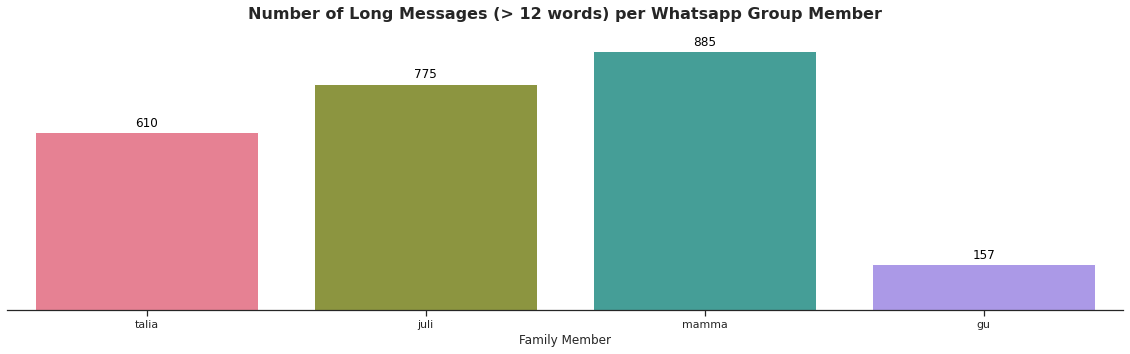

In [14]:
df_wcount = df[(df['word_count'] >=12)]
plt.figure(figsize=(20,5))
ax = sns.countplot(x = df_wcount['username'], palette = 'husl', order = ['talia','juli','mamma','gu'])
for p in ax.patches:
        ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(0, 3),rotation = 'horizontal',textcoords='offset points')
ax.set_xlabel('Family Member')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False)  
plt.title('Number of Long Messages (> 12 words) per Whatsapp Group Member', fontsize = 16,weight = 'bold',pad=20);  
sns.despine(top=True, right=True, left=True, bottom=False)

In [15]:
def percentile_drop(df,column):
    q25, q75 = np.percentile(df[column], 25), np.percentile(df[column], 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    #print ('lower: %d upper: %d' % (lower,upper))
    drop_index = df[(df[column] >=upper) | (df[column] <=lower)].index
    #print('Number of rows to be removed %d'% drop_index.shape[0])
    return drop_index

In [16]:
df.drop(percentile_drop(df,'word_count'), inplace = True)
df.drop(percentile_drop(df,'char_count'), inplace = True)

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<h3>The One who sends the Longest Messages</h3>
<ul>
<li>'mamma' is the group member that has sent most messages above the upper-quantile cutoff. I am not very far behind
<li>As a classic male characteristic, my brother presents lower participation in analysis
<li>The result makes sense since 'juli' and 'mamma' presented also the most extreme outliers<br>
The rest of the analysis is performed by removing the outliers from the dataset
<ul>
</blockquote>

Here we plot the BoxPlot analysis again, without the outliers for the first two plots, for better visualisation:

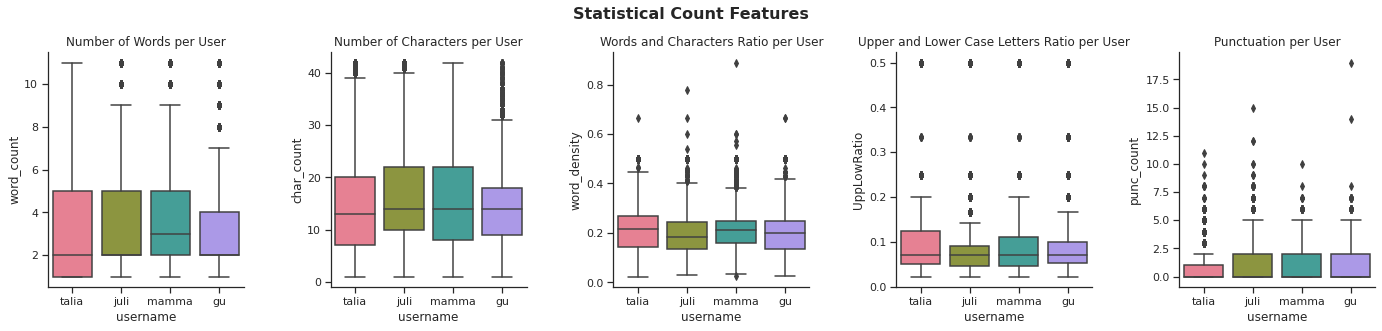

In [17]:
fig, axarr = plt.subplots(1,5, figsize=(20, 5))

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

feats = ['word_count','char_count','word_density','UppLowRatio','punc_count']
z = 0
for j in range(0,5):
    ax = sns.boxplot(data = df, x = 'username', y = df[feats[z]], ax=axarr[j],palette = 'husl');
    z +=1
        
axarr[0].set_title("Number of Words per User")
axarr[1].set_title("Number of Characters per User")
axarr[2].set_title("Words and Characters Ratio per User")
axarr[3].set_title("Upper and Lower Case Letters Ratio per User")
axarr[4].set_title("Punctuation per User")
fig.tight_layout(pad=3.0)
plt.suptitle('Statistical Count Features',fontsize=16, weight = 'bold');
      
plt.show()

Now that the extreme outliers have been removed, we can analyse the KDE plot again.

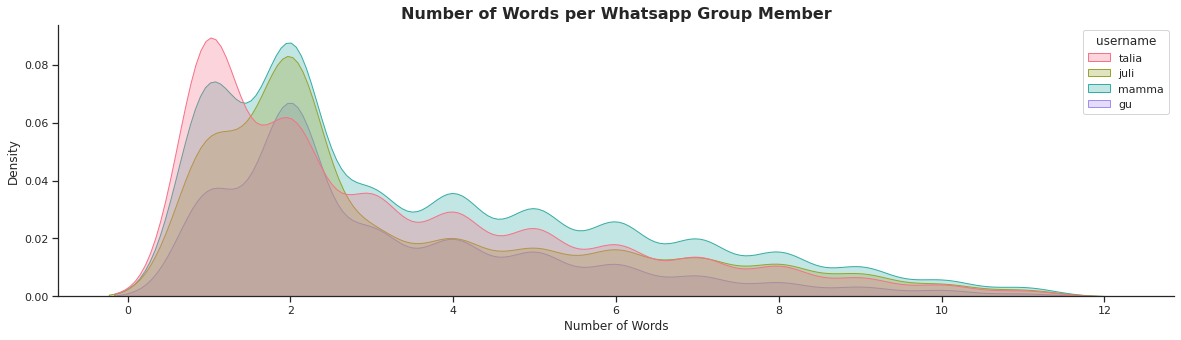

In [18]:
plt.figure(figsize=(20,5))
ax = sns.kdeplot(data = df, x = 'word_count', linewidth=1,alpha=.3, fill = True, hue = 'username',palette = 'husl')    
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.title("Number of Words per Whatsapp Group Member",fontsize=16, weight = 'bold'); 
sns.despine(top=True, right=True, left=False, bottom=False)

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<h3>The One who sends the Shortest Messages</h3>
<ul>
<li>The KDE plot tells us many words each user prefers to communicate. The higher the peak, the more messages with this amount of words
<li>'juli','mamma' and 'gu' all present similar distribution shapes. With most messages containing 2 words
<li>'talia' is the only member that peaks at 1 word, with 'mamma' also presenting an expressive secondary peak there <br>
<ul>
</blockquote>

Below is an example of the short messages:

In [19]:
ex = df[(df['word_count'] <=2)]
rows = np.random.choice(ex.index.values, 2,replace=False)
ex.loc[rows,['message','word_count','username']]

,message,word_count,username
12691,kkkk,1,mamma
22625,<media omitted>,2,talia


The raw file also provides a piece of basic media information. When downloading the WhatsApp data, I selected to omit the data to obtain a lighter file. 

The messages that contained images or video are marked with **media omitted** message. It is rather a surprise to see who is clogging my phone with data:

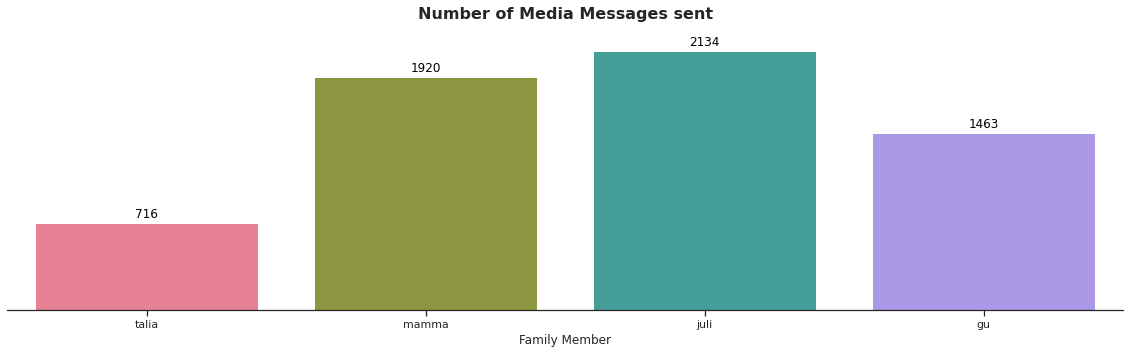

In [20]:
media = df[(df['message'] =='<media omitted>')]

plt.figure(figsize=(20,5))
ax = sns.countplot(x = media['username'], palette = 'husl')
for p in ax.patches:
        ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(0, 3),rotation = 'horizontal',textcoords='offset points')
ax.set_xlabel('Family Member')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False)  
plt.title('Number of Media Messages sent', fontsize = 16,weight = 'bold',pad=20);  
sns.despine(top=True, right=True, left=True, bottom=False)


<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<h3>The One who sends Cats Videos</h3>
<ul>
<li>Well, I am the person who sends most images or video files. It could be an explanation why I never have space on my phone to download what other people send me
<li>One of the few analysis where 'gu' is not last
<li>'talia' number of media messages accounts for 30% of the data I have sent
<ul>
</blockquote>

# Year, Months and Weekdays

In this section, we start to analyse the message regarding its date. First, let's see how many messages each member has sent over the years:

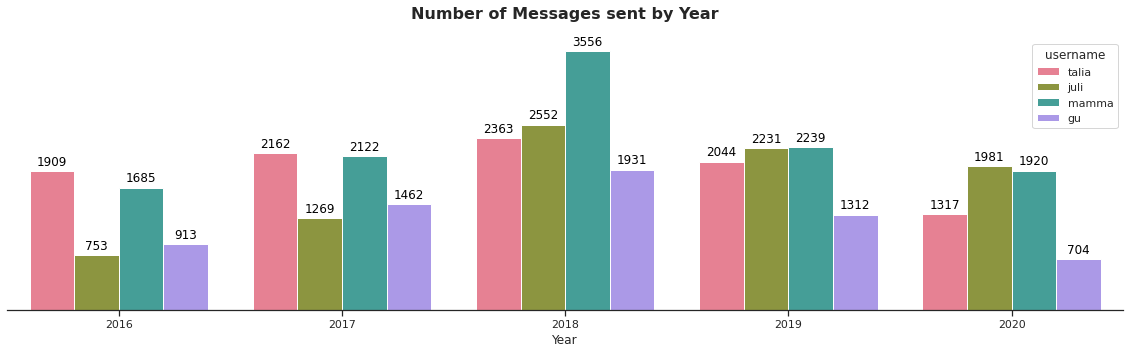

In [21]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x = df['year'], hue = df['username'],palette = 'husl')
for p in ax.patches:
        ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(0, 3),rotation = 'horizontal',textcoords='offset points')
ax.set_xlabel('Year')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False)  
plt.title('Number of Messages sent by Year', fontsize = 16,weight = 'bold',pad=20);  
sns.despine(top=True, right=True, left=True, bottom=False)

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<h3>The One who keeps the Group Alive</h3>
<ul>
<li>For 2016 and 2020 there is not a whole year of data, so the numbers can present a lower trend than usual
<li>'mamma' and 'talia' are fighting for the top two positions from 2016 to 2018. After this 'juli' and 'mamma' take over
<li>In 2016 and 2017 are the only years where 'gu' surpasses other group members
<li>2018 has a higher number of messages, from all members. The record goes to 'mamma' with more than 3.500 messages sent
<ul>
</blockquote>

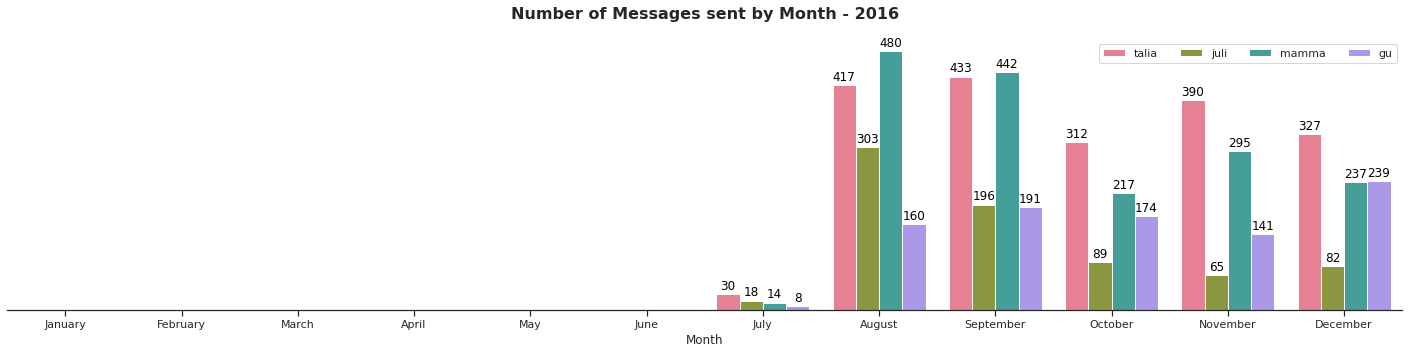

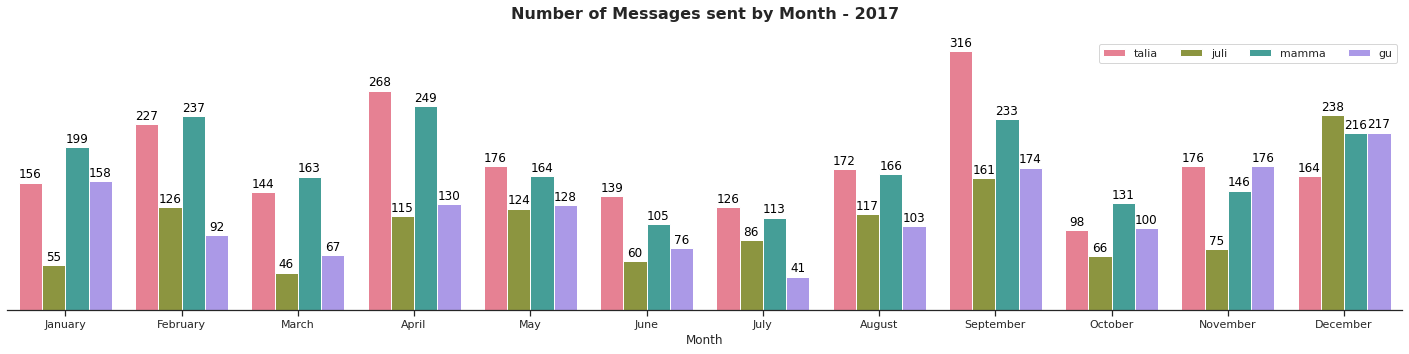

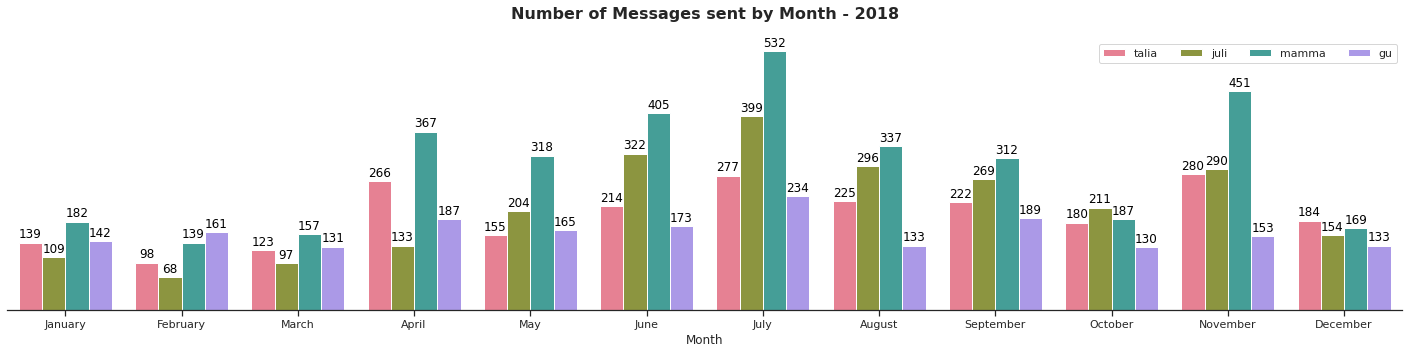

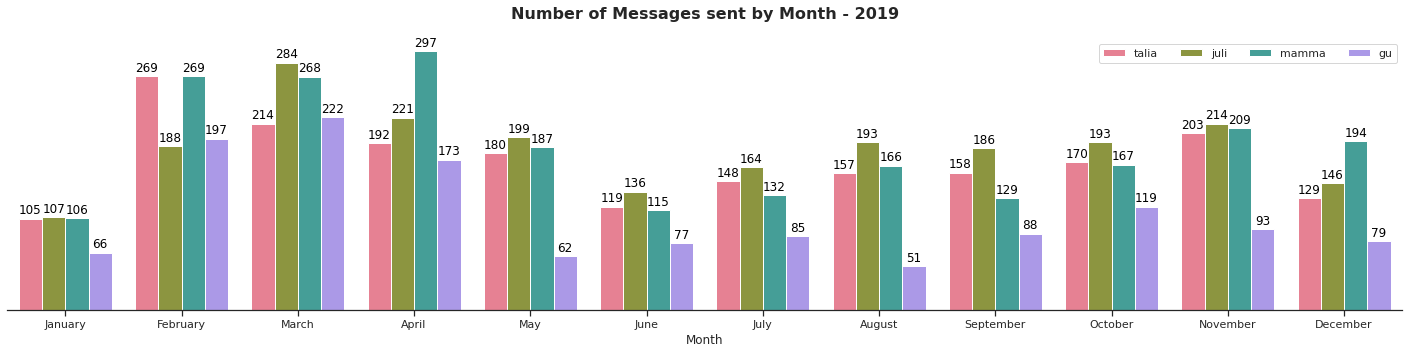

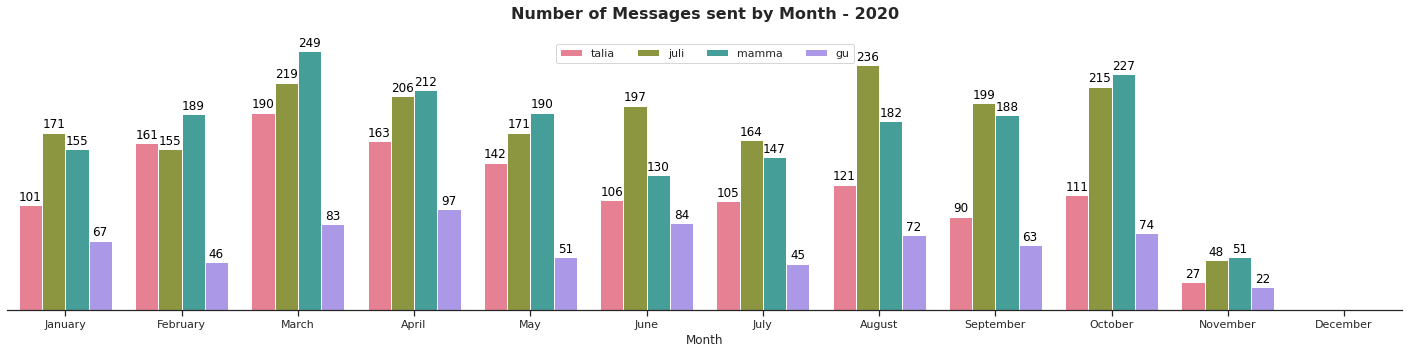

In [22]:
month_order = list(calendar.month_name)

for i in df['year'].unique():
    df_y = df[df['year']==i]
    plt.figure(figsize=(25,5))
    ax = sns.countplot(x =df_y['month'] , hue = df_y['username'],palette = 'husl', 
                       order = month_order[1:13],hue_order = df['username'].unique())
    for p in ax.patches:
        try:
            ax.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
                ha='center', va='bottom', color='black', xytext=(0, 2),rotation = 'horizontal',textcoords='offset points')
        except: continue
    ax.set_xlabel('Month')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False)  
    ax.legend(ncol=len(df['username'].unique()))
    plt.title('Number of Messages sent by Month - ' + str(i), fontsize = 16,weight = 'bold',pad=20);  
    sns.despine(top=True, right=True, left=True, bottom=False)

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<h3>Wait...What year is it?</h3>
<ul>
<li>Overall, there is not a great distinction between the years: 'mamma' is consistently at the top two, and my brother sending fewer messages than my sister and I
<li>From May 2018 and onwards, 'juli' has usually sent more messages than 'talia'. It seems to be connected to the period I left a previous job
<li>August and September 2016 are the only periods where more than one user has sent over 400 messages. It was probably excitement as the group had recently started
<li>'gu' has sent over 200 messages solely in December 2016 and 2017, and in July 2018. Interestingly, the dates coincide with the periods where we were spending Holidays together
<ul>
</blockquote>

Analysing the years and months, it becomes natural to get curious regarding Weekdays. The bar plot displays the sum of all messages per Week Day:

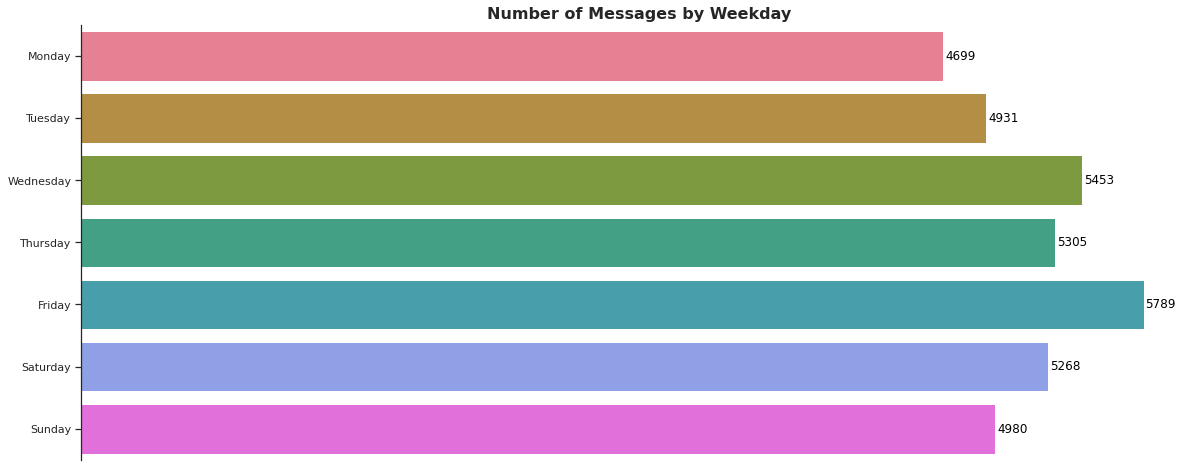

In [23]:
day_order = list(calendar.day_name)

plt.figure(figsize=(20,8))

ax = sns.countplot(data=df, y = 'weekday', palette = 'husl', order = day_order)

for p in ax.patches:
        width = int(p.get_width())
        ax.annotate("%d" % p.get_width(), (width, p.get_y() + p.get_height()/ 2),
        ha='left', va='center', color='black', xytext=(2, 0),rotation = 'horizontal',textcoords='offset points')
        

sns.despine(top=True, right=True, left=False, bottom=True)
ax.set_xlabel('Number of Occurrences')
ax.set(ylabel=None)
ax.set(xticklabels=[])
ax.axes.get_xaxis().set_visible(False) 

plt.title("Number of Messages by Weekday", fontsize = 16,weight = 'bold');


A heatmap is a good way to visualise patterns between features. 

In the plot below we have the Days of the Week, the Months and the colours represent the sum of all messages exchanged (considering the particular day and month):

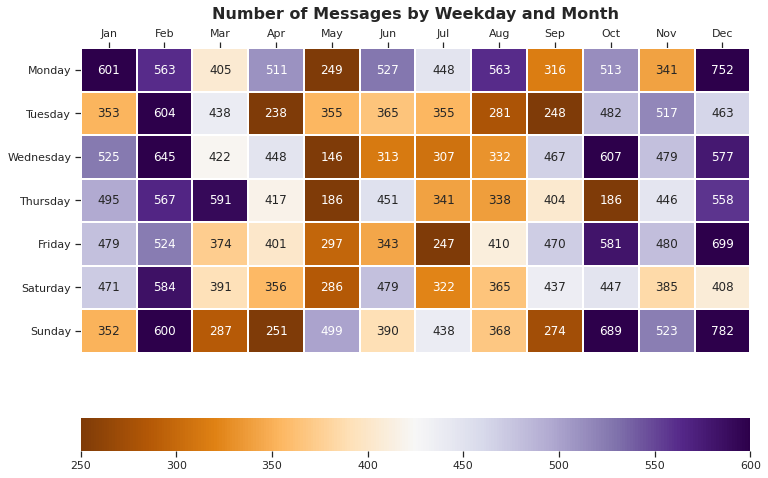

In [24]:
DayMonth = df.groupby(['weekday','month']).size().reset_index(name='counts')

DayMonth_wide = DayMonth.pivot(index='weekday', columns='month', values='counts')
#Order columns and Index
month_order_abbr = list(calendar.month_abbr)
DayMonth_wide.columns = month_order_abbr[1:13]
DayMonth_wide.index = day_order

plt.figure(figsize=(12,8))

ax = sns.heatmap(DayMonth_wide, annot=True, fmt='.0f', yticklabels='auto', cmap='PuOr', 
                 linewidths=1.8, cbar_kws={"orientation": "horizontal"},vmin = 250,vmax = 600)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
ax.set_title('Number of Messages by Weekday and Month',fontsize = 16,weight = 'bold',pad=10)
plt.show()

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<h3>That time of the month when...</h3>
<ul>
<li>The bar graph showed that there is not a great distinction between the days of the week. The most active day is Friday, with Sunday and Monday being the least active  
<li>The heatmap is a visual aid to detect patterns between Weekdays, Months and the Number of Messages exchanged
<li>The number of messages is more dependent on the Month than the Weekdays. For the most part, the rows (Weekdays) follow the colour pattern of the columns (Month)
<li>From the contrasting colour pattern in the central area of the plot we conclude that months from April to August are usually when fewer messages are sent 
<li>February is the only month where all the Weekdays had more than 500 messages exchanged    
<ul>
</blockquote>

# Most Active Day Period
Now, let's visualise the most active periods of the day for chatting. To improve the visualisation of patterns, we divide the 24h of the day into the following periods:

* **Early Morning:** From 4 am to 8 am
* **Morning:** From 8 am to 12 pm
* **Noon:** 12 pm to 4 pm
* **Evening:** 4 pm to 8 pm
* **Night:** 8 pm to 12 am
* **Late Night:** 12 am to 4 am

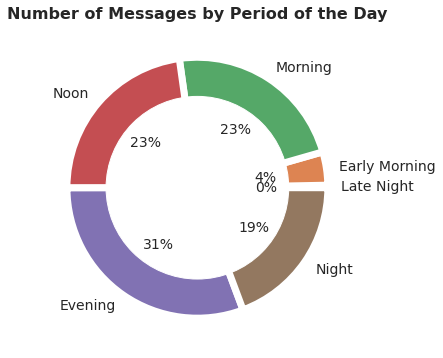

In [25]:
df_hour = df.loc[:,['hour','Date', 'username','message','word_count','char_count']]
df_hour['period'] = (df_hour['Date'].dt.hour % 24 + 4) // 4
df_hour['period_code'] = (df_hour['Date'].dt.hour % 24 + 4) // 4
df_hour['period'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

username_hour = df_hour.groupby(['period','username']).size().reset_index(name='counts')
hour = df_hour.groupby(['period','period_code']).size().reset_index(name='counts')
hour.sort_values('period_code', inplace = True)

# Create a pieplot
pie, ax = plt.subplots(figsize=[10,6])
ax = plt.pie(x=hour['counts'], labels=hour['period'],wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
            autopct='%.0f%%',pctdistance=0.53, labeldistance=1.1,textprops={'fontsize': 14})

# add a circle at the center to transform it in a donut chart
inner_circle=plt.Circle((0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(inner_circle)
plt.title("Number of Messages by Period of the Day", fontsize = 16,weight = 'bold');
plt.show()

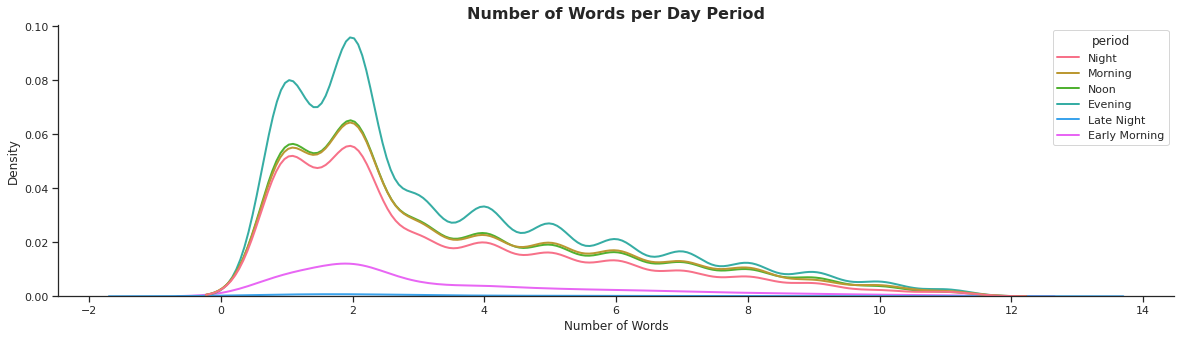

In [26]:
plt.figure(figsize=(20,5))
ax = sns.kdeplot(data = df_hour, x = 'word_count', linewidth=2,alpha=.3, fill = False, hue = 'period',palette = 'husl')    
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.title("Number of Words per Day Period",fontsize=16, weight = 'bold'); 
sns.despine(top=True, right=True, left=False, bottom=False)

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<h3>Is now a good time to talk?</h3>
<ul>
<li>The pie chart shows that the conversation is alive for the greatest part of the day
<li>Only Early Morning and Late Night periods have a clear drop in message numbers
<li>The evening period is the preferred time to chat, with 10% more messages than Morning, Noon or Night
<li>The KDE plot is quite similar across the main periods of the day, i.e. there's no specific period of the day to send bigger messages
<li>Late Night and Early Morning a gaussian-like curve is present with most messages containing two words. Could be because of "Good Morning" or "Good Night" messages
<ul>
</blockquote>

# Conclusion
The notebook aimed to understand the pattern in my family WhatsApp group. In total, almost 40.000 messages were exchanged between the four of us, with 'mamma' being the most active user and me the ones that clog people phones with media messages.

The majority of messages are short, with one or two words and the time where most messages are exchanged is the Evening. The data contained a few outliers, with messages up to 175 words or 800 characters. The analysis always showed that the conversation is less active from April to August. In contrast, February has shown to be a communicative month for us. 

I hope you enjoyed reading as much as I enjoyed analysing this data.